# Tutorial: RL Likelihood Abstraction Framework

This tutorial introduces the new reinforcement learning (RL) likelihood abstraction framework added to HSSM. This framework provides a flexible, composable system for building log-likelihood functions where some parameters are computed by other models—such as drift rates derived from reinforcement learning processes.

## What's New?

This PR introduces:

1. **`@annotate_function` decorator**: Attach metadata to functions describing their inputs, outputs, and computed dependencies
2. **`make_rl_logp_func` factory**: Automatically builds complete log-likelihood functions from annotated components
3. **Column indexing utilities**: Smart parameter resolution from data matrices and parameter arrays
4. **JAX-based RL computation functions**: Efficient trial-wise drift rate computation with `jax.lax.scan`

## Key Benefits

- **Composability**: Stack models together using function annotations
- **Automatic parameter resolution**: The system figures out where parameters come from (data, model params, or computed)
- **Type safety**: Protocol-based type hints for static checking
- **Efficiency**: JAX vectorization and JIT compilation for performance

## Overview

The framework enables you to:
1. Define RL update rules that compute trial-wise parameters (e.g., drift rates)
2. Annotate functions with their parameter dependencies
3. Automatically compose them into complete likelihood functions

Let's dive in!

## Setup

In [21]:
from pprint import pp

import numpy as np
import jax
import jax.numpy as jnp
from jax.lax import scan

import hssm
from hssm.likelihoods.rldm_optimized_abstraction import (
    annotate_function,
    make_rl_logp_func,
    compute_v_trial_wise,
    compute_v_subject_wise,
    angle_logp_jax_func,
    _get_column_indices,
    _get_column_indices_with_computed,
    _collect_cols_arrays,
)

hssm.set_floatX("float32")

# Set random seed for reproducibility
np.random.seed(42)

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


## Part 1: The `@annotate_function` Decorator

The `@annotate_function` decorator is the foundation of the framework. It attaches metadata to functions, describing:
- **inputs**: Parameters the function needs
- **outputs**: Values the function produces
- **computed**: Which inputs are computed by other annotated functions

This metadata enables automatic parameter resolution and dependency tracking.

In [22]:
# Example: A simple annotated function
@annotate_function(
    inputs=["param1", "param2"],
    outputs=["result"],
    description="Multiplies two parameters"
)
def example_function(data):
    param1, param2 = data[:, 0], data[:, 1]
    return param1 * param2

# The metadata is now attached to the function
(vars(example_function))

{'__wrapped__': <function __main__.example_function(data)>,
 'inputs': ['param1', 'param2'],
 'outputs': ['result'],
 'description': 'Multiplies two parameters'}

### Example 2: Computed Parameters

The real power comes from specifying dependencies between functions. Here's how you can create a function that depends on computed parameters:

In [23]:
# Define a function that computes an intermediate value
@annotate_function(
    inputs=["learning_rate", "reward", "old_value"],
    outputs=["new_value"]
)
def update_value(data):
    """Compute a new value using a simple learning rule."""
    learning_rate, reward, old_value = data[:, 0], data[:, 1], data[:, 2]
    new_value = old_value + learning_rate * (reward - old_value)
    return new_value

# Define a function that uses the computed value
@annotate_function(
    inputs=["new_value", "scaling_factor", "baseline"],
    outputs=["final_output"],
    computed={"new_value": update_value}  # Specify that new_value is computed
)
def compute_output(data):
    """Transform the computed value into a final output."""
    new_value, scaling_factor, baseline = data[:, 0], data[:, 1], data[:, 2]
    return (new_value - baseline) * scaling_factor

# Inspect the metadata
print("Function 1 (intermediate computation):")
print(f"  Inputs:  {update_value.inputs}")
print(f"  Outputs: {update_value.outputs}")
print(f"  Computed: {getattr(update_value, 'computed', {})}")

print("\nFunction 2 (depends on Function 1):")
print(f"  Inputs:  {compute_output.inputs}")
print(f"  Outputs: {compute_output.outputs}")
print(f"  Computed: {list(compute_output.computed.keys())}")

print("\n💡 Key insight: 'new_value' is listed as an input to compute_output,")
print("   but it's also in the 'computed' dict, meaning the framework will")
print("   automatically call update_value() to compute it!")

Function 1 (intermediate computation):
  Inputs:  ['learning_rate', 'reward', 'old_value']
  Outputs: ['new_value']
  Computed: {}

Function 2 (depends on Function 1):
  Inputs:  ['new_value', 'scaling_factor', 'baseline']
  Outputs: ['final_output']
  Computed: ['new_value']

💡 Key insight: 'new_value' is listed as an input to compute_output,
   but it's also in the 'computed' dict, meaning the framework will
   automatically call update_value() to compute it!


This pattern is exactly how the RL-SSM framework works: the drift rate `v` is computed by an RL learning function, then passed to the SSM likelihood function. The `@annotate_function` decorator makes these dependencies explicit and allows the system to automatically resolve them.

## Part 2: Column Indexing and Parameter Resolution

When building RL-SSM models, parameters come from three sources:
1. **Data columns**: Observable data like `rt`, `response`, `feedback`
2. **Model parameters**: Estimated parameters like `rl.alpha`, `scaler`, `a`, `z`, `t`
3. **Computed parameters**: Values computed by other functions, like drift rate `v`

The framework provides utilities to automatically resolve where each parameter comes from.

### 2.1 Basic Column Indexing with `_get_column_indices`

This function maps parameter names to their sources and indices.

In [24]:
# Define available data sources
data_cols = ["rt", "response"]  # Columns in the data matrix
list_params = ["rl.alpha", "scaler", "a", "z", "t", "theta"]  # Model parameters
extra_fields = ["feedback"]  # Additional fields (e.g., trial feedback)

# Which parameters do we need for our RL computation?
cols_to_look_up = ["rl.alpha", "scaler", "response", "feedback"]

# Get indices
indices = _get_column_indices(cols_to_look_up, data_cols, list_params, extra_fields)
print("\nParameter source mapping:")
pp(indices)


Parameter source mapping:
{'rl.alpha': ('args', 0),
 'scaler': ('args', 1),
 'response': ('data', 1),
 'feedback': ('args', 6)}


### 2.2 Collecting Arrays with `_collect_cols_arrays`

Once we know where parameters come from, we can extract them from the data.

In [25]:
# Create mock data
n_trials = 10
data = np.column_stack([
    np.random.uniform(0.3, 1.5, n_trials),  # rt
    np.random.choice([-1, 1], n_trials)     # response
])

# Create mock parameter arrays
rl_alpha = np.ones(n_trials) * 0.6
scaler = np.ones(n_trials) * 3.2
a = np.ones(n_trials) * 1.2
z = np.ones(n_trials) * 0.5
t = np.ones(n_trials) * 0.1
theta = np.ones(n_trials) * 0.3
feedback = np.random.choice([0, 1], n_trials)  # reward feedback

_args = [rl_alpha, scaler, a, z, t, theta, feedback]

# Collect the arrays we need
collected = _collect_cols_arrays(data, _args, indices)

print(f"Collected {len(collected)} arrays:")
for i, (param, arr) in enumerate(zip(cols_to_look_up, collected)):
    print(f"  {param:12}: shape {arr.shape}, first 3 values = {arr[:3]}")

Collected 4 arrays:
  rl.alpha    : shape (10,), first 3 values = [0.6 0.6 0.6]
  scaler      : shape (10,), first 3 values = [3.2 3.2 3.2]
  response    : shape (10,), first 3 values = [ 1. -1.  1.]
  feedback    : shape (10,), first 3 values = [0 0 1]


### 2.3 Advanced: Resolving Computed Parameters

The `_get_column_indices_with_computed` function identifies which parameters need to be computed by other functions.

In [26]:
# Create a mock SSM likelihood function that needs both regular and computed params
class MockSSMLogpFunc:
    inputs = ["v", "a", "z", "t", "theta", "rt", "response"]

# Resolve which are available and which need to be computed
result = _get_column_indices_with_computed(
    MockSSMLogpFunc(), data_cols, list_params, extra_fields
)
pp(vars(result))

print("\nFound parameters (available from data/args):")
for param, (source, idx) in result.colidxs.items():
    print(f"  {param:10} -> {source:6} at index {idx}")

print(f"\nComputed parameters (need to be calculated): {result.computed}")
print("\nNotice that 'v' (drift rate) is marked as computed—it will be")
print("calculated by the RL model from trial feedback!")

{'colidxs': {'a': ('args', 2),
             'z': ('args', 3),
             't': ('args', 4),
             'theta': ('args', 5),
             'rt': ('data', 0),
             'response': ('data', 1)},
 'computed': ['v']}

Found parameters (available from data/args):
  a          -> args   at index 2
  z          -> args   at index 3
  t          -> args   at index 4
  theta      -> args   at index 5
  rt         -> data   at index 0
  response   -> data   at index 1

Computed parameters (need to be calculated): ['v']

Notice that 'v' (drift rate) is marked as computed—it will be
calculated by the RL model from trial feedback!


## Part 3: Computed Parameter Computation (drifts in this example)

In RL-DDM models, the drift rate on each trial depends on learned Q-values. The framework provides JAX-based functions for efficient computation.

### 3.1 Trial-wise computation with `compute_v_trial_wise`

This function implements one step of the RL update rule using temporal difference (TD) learning.

In [27]:
# Single trial example
q_val = jnp.array([0.5, 0.5])  # Initial Q-values for two alternatives
trial_data = jnp.array([
    0.6,   # rl.alpha (learning rate)
    3.2,   # scaler (weight for Q-value difference)
    1,     # action (response: 0 or 1)
    1.0    # reward (feedback: 0 or 1)
])

# Compute drift rate and update Q-values
new_q_val, drift_rate = compute_v_trial_wise(q_val, trial_data)

print("Single trial RL update:")
print(f"  Initial Q-values: {q_val}")
print(f"  Action taken: {int(trial_data[2])}")
print(f"  Reward received: {trial_data[3]}")
print(f"  Computed drift rate (v): {drift_rate:.4f}")
print(f"  Updated Q-values: {new_q_val}")
print(f"\n  Note: Q-value for chosen action increased (reward = 1)")

Single trial RL update:
  Initial Q-values: [0.5 0.5]
  Action taken: 1
  Reward received: 1.0
  Computed drift rate (v): 0.0000
  Updated Q-values: [0.5 0.8]

  Note: Q-value for chosen action increased (reward = 1)


### 3.2 Subject-wise computation with `compute_v_subject_wise`

This function processes all trials for a subject using `jax.lax.scan` for efficiency.

In [28]:
# Simulate a sequence of trials for one subject
n_trials_subject = 20
subject_data = jnp.array([
    jnp.ones(n_trials_subject) * 0.6,           # rl.alpha (constant)
    jnp.ones(n_trials_subject) * 3.2,           # scaler (constant)
    np.random.choice([0, 1], n_trials_subject), # actions (varying)
    np.random.choice([0, 1], n_trials_subject)  # rewards (varying)
]).T  # Shape: (n_trials, 4)

# Compute drift rates for all trials
drift_rates = compute_v_subject_wise(subject_data)

print(f"Computed drift rates for {n_trials_subject} trials:")
print(f"  Shape: {drift_rates.shape}")
print(f"  Range: [{drift_rates.min():.3f}, {drift_rates.max():.3f}]")
print(f"  Mean: {drift_rates.mean():.3f}")
print(f"\n  First 5 drift rates: {drift_rates[:5]}")
print(f"\n  Drift rates vary based on accumulated Q-value differences!")

Computed drift rates for 20 trials:
  Shape: (20,)
  Range: [-0.154, 3.018]
  Mean: 1.727

  First 5 drift rates: [0.         0.96000004 1.3440001  0.384      0.        ]

  Drift rates vary based on accumulated Q-value differences!


## Part 4: Building Complete Likelihoods with `make_rl_logp_func`

Now for the main event! The `make_rl_logp_func` factory automatically:
1. Identifies which parameters come from data vs. model parameters
2. Computes derived parameters (like drift rates from RL)
3. Assembles everything into a complete log-likelihood function

### 4.1 Setting up the components

In [29]:
# Step 1: Annotate the RL computation function
compute_v_annotated = annotate_function(
    inputs=["rl.alpha", "scaler", "response", "feedback"],
    outputs=["v"]
)(compute_v_subject_wise)

pp(vars(compute_v_annotated))

{'__wrapped__': <function compute_v_subject_wise at 0x7f61284fcb80>,
 'inputs': ['rl.alpha', 'scaler', 'response', 'feedback'],
 'outputs': ['v']}


In [30]:
# Step 2: Annotate the SSM likelihood function
# This function needs 'v' as input, but 'v' is computed by our RL function
ssm_logp_annotated = annotate_function(
    inputs=["v", "a", "z", "t", "theta", "rt", "response"],
    computed={"v": compute_v_annotated}  # Specify the dependency
)(angle_logp_jax_func)

pp(vars(ssm_logp_annotated))

{'__wrapped__': <function make_jax_matrix_logp_funcs_from_onnx.<locals>.logp at 0x7f61284fccc0>,
 'inputs': ['v', 'a', 'z', 't', 'theta', 'rt', 'response'],
 'computed': {'v': <function compute_v_subject_wise at 0x7f61284fd800>}}


### 4.2 Creating the complete log-likelihood function

In [31]:
# Simulation parameters
n_participants = 5
n_trials_per_subject = 40
total_trials = n_participants * n_trials_per_subject

# Create complete dataset
data_matrix = np.column_stack([
    np.random.uniform(0.3, 1.5, total_trials),  # rt
    np.random.choice([-1, 1], total_trials)     # response
])

# Define parameter structure
data_cols = ["rt", "response"]
list_params = ["rl.alpha", "scaler", "a", "z", "t", "theta"]
extra_fields = ["feedback"]

# Build the log-likelihood function!
logp_func = make_rl_logp_func(
    ssm_logp_func=ssm_logp_annotated,
    n_participants=n_participants,
    n_trials=n_trials_per_subject,
    data_cols=data_cols,
    list_params=list_params,
    extra_fields=extra_fields
)

print("Complete log-likelihood function created!")
print(f"\nThis function will:")
print(f"  1. Extract parameters from data and args")
print(f"  2. Compute drift rates using the RL model")
print(f"  3. Evaluate the SSM likelihood")
print(f"  4. Return log-likelihood for all {total_trials} trials")

Complete log-likelihood function created!

This function will:
  1. Extract parameters from data and args
  2. Compute drift rates using the RL model
  3. Evaluate the SSM likelihood
  4. Return log-likelihood for all 200 trials


### 4.3 Using the log-likelihood function

Log-likelihood evaluation:
  Output shape: (200,)
  Total log-likelihood: -313.17
  Per-trial range: [-4.29, 0.38]
  Mean per-trial: -1.57


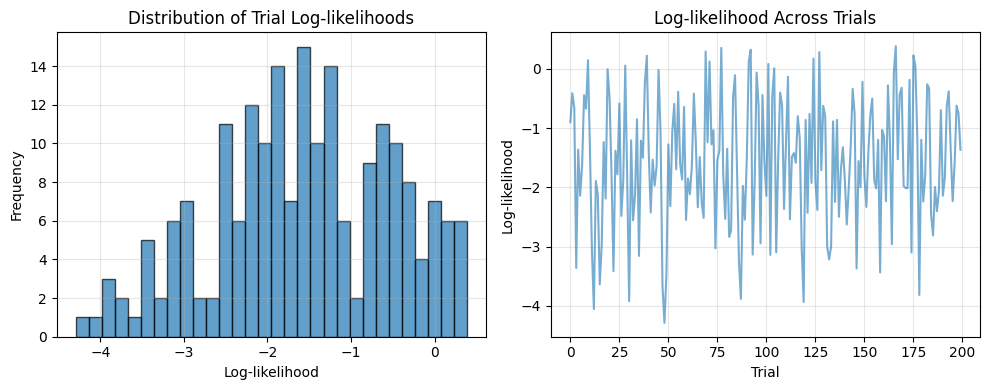

In [32]:
# Create parameter arrays
rl_alpha = np.ones(total_trials) * 0.6
scaler = np.ones(total_trials) * 3.2
a = np.ones(total_trials) * 1.2
z = np.ones(total_trials) * 0.5
t = np.ones(total_trials) * 0.1
theta = np.ones(total_trials) * 0.3
feedback = np.random.choice([0, 1], total_trials)

# Evaluate log-likelihood
logp_values = logp_func(data_matrix, rl_alpha, scaler, a, z, t, theta, feedback)

print(f"Log-likelihood evaluation:")
print(f"  Output shape: {logp_values.shape}")
print(f"  Total log-likelihood: {logp_values.sum():.2f}")
print(f"  Per-trial range: [{logp_values.min():.2f}, {logp_values.max():.2f}]")
print(f"  Mean per-trial: {logp_values.mean():.2f}")

# Visualize distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(logp_values, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Log-likelihood')
plt.ylabel('Frequency')
plt.title('Distribution of Trial Log-likelihoods')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(logp_values, alpha=0.6)
plt.xlabel('Trial')
plt.ylabel('Log-likelihood')
plt.title('Log-likelihood Across Trials')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Part 5: Complete Example with Real RLDM Data

Let's put it all together with a realistic example using RLDM data.

In [33]:
# This example mirrors the test case from test_rldm_likelihood_abstraction.py

# 1. Define data structure
n_subjects = 10
n_trials = 100
total_trials = n_subjects * n_trials

# Create synthetic RLDM data
participant_id = np.repeat(np.arange(n_subjects), n_trials)
trial = np.tile(np.arange(n_trials), n_subjects)
rt = np.random.uniform(0.3, 2.0, total_trials)
response = np.random.choice([-1, 1], total_trials)
feedback = np.random.choice([0, 1], total_trials)

data = np.column_stack([rt, response])

print(f"Dataset created:")
print(f"  Subjects: {n_subjects}")
print(f"  Trials per subject: {n_trials}")
print(f"  Total trials: {total_trials}")
print(f"  Data shape: {data.shape}")

Dataset created:
  Subjects: 10
  Trials per subject: 100
  Total trials: 1000
  Data shape: (1000, 2)


In [34]:
# 2. Annotate functions
compute_v_subject_wise_annotated = annotate_function(
    inputs=["rl.alpha", "scaler", "response", "feedback"],
    outputs=["v"],
)(compute_v_subject_wise)

ssm_logp_func = annotate_function(
    inputs=["v", "a", "z", "t", "theta", "rt", "response"],
    computed={"v": compute_v_subject_wise_annotated},
)(angle_logp_jax_func)

print("Functions annotated successfully")

Functions annotated successfully


In [35]:
# 3. Set up parameter arrays
rl_alpha = np.ones(total_trials) * 0.60
scaler = np.ones(total_trials) * 3.2
a = np.ones(total_trials) * 1.2
z = np.ones(total_trials) * 0.1
t = np.ones(total_trials) * 0.1
theta = np.ones(total_trials) * 0.1

print("Parameter arrays created:")
print(f"  rl.alpha (learning rate): {rl_alpha[0]}")
print(f"  scaler (Q-diff weight): {scaler[0]}")
print(f"  a (threshold): {a[0]}")
print(f"  z (starting point): {z[0]}")
print(f"  t (non-decision time): {t[0]}")
print(f"  theta (angle): {theta[0]}")

Parameter arrays created:
  rl.alpha (learning rate): 0.6
  scaler (Q-diff weight): 3.2
  a (threshold): 1.2
  z (starting point): 0.1
  t (non-decision time): 0.1
  theta (angle): 0.1


In [36]:
# 4. Build the log-likelihood function
data_cols = ["rt", "response"]
list_params = ["rl.alpha", "scaler", "a", "z", "t", "theta"]
extra_fields = ["feedback"]

logp_fn = make_rl_logp_func(
    ssm_logp_func,
    n_participants=n_subjects,
    n_trials=n_trials,
    data_cols=data_cols,
    list_params=list_params,
    extra_fields=extra_fields,
)

print("\nLog-likelihood function built successfully!")


Log-likelihood function built successfully!


In [37]:
# 5. Evaluate the log-likelihood
result = logp_fn(data, rl_alpha, scaler, a, z, t, theta, feedback)

print(f"\nLog-likelihood evaluation complete:")
print(f"  Output shape: {result.shape}")
print(f"  Expected: ({total_trials},)")
print(f"  Match: {result.shape[0] == total_trials}")
print(f"\n  Total log-likelihood: {result.sum():.2f}")
print(f"  Mean per trial: {result.mean():.2f}")
print(f"  Std per trial: {result.std():.2f}")


Log-likelihood evaluation complete:
  Output shape: (1000,)
  Expected: (1000,)
  Match: True

  Total log-likelihood: -3235.61
  Mean per trial: -3.24
  Std per trial: 2.08


## Part 6: Key Design Patterns

### Pattern 1: Function Composition

The framework allows you to compose functions hierarchically:

In [38]:
# Example: Multi-level computation

@annotate_function(
    inputs=["param_a", "param_b"],
    outputs=["intermediate"]
)
def compute_intermediate(data):
    return data[:, 0] + data[:, 1]

@annotate_function(
    inputs=["intermediate", "param_c"],
    outputs=["final"],
    computed={"intermediate": compute_intermediate}
)
def compute_final(data):
    return data[:, 0] * data[:, 1]

print("Hierarchical function composition:")
print(f"  Level 1: {compute_intermediate.inputs} -> {compute_intermediate.outputs}")
print(f"  Level 2: {compute_final.inputs} -> {compute_final.outputs}")
print(f"  Computed: {list(compute_final.computed.keys())}")
print(f"\n  The framework will automatically resolve the dependency chain!")

Hierarchical function composition:
  Level 1: ['param_a', 'param_b'] -> ['intermediate']
  Level 2: ['intermediate', 'param_c'] -> ['final']
  Computed: ['intermediate']

  The framework will automatically resolve the dependency chain!


### Pattern 2: Parameter Source Flexibility

Parameters can come from any combination of sources:

In [39]:
# Example: Mixing data, parameters, and computed values
data_cols = ["rt", "response", "stimulus"]
list_params = ["threshold", "drift_base"]
extra_fields = ["trial_difficulty"]

@annotate_function(
    inputs=["drift_base", "stimulus", "trial_difficulty"],
    outputs=["drift_rate"]
)
def compute_drift(data):
    return data[:, 0] + data[:, 1] * data[:, 2]

print("Parameter sources:")
print(f"  From data: stimulus")
print(f"  From params: drift_base")
print(f"  From extra: trial_difficulty")
print(f"\n  The framework handles all three sources seamlessly!")

Parameter sources:
  From data: stimulus
  From params: drift_base
  From extra: trial_difficulty

  The framework handles all three sources seamlessly!


## Part 7: Advanced Usage and Tips

### Tip 1: Debugging Parameter Resolution

Use the column indexing functions to verify your setup:

In [40]:
# Debugging helper
def debug_parameter_resolution(func, data_cols, list_params, extra_fields):
    """Print detailed parameter resolution information."""
    result = _get_column_indices_with_computed(
        func, data_cols, list_params, extra_fields
    )

    print("Parameter Resolution Debug Info:")
    print("=" * 50)
    print(f"Function inputs: {func.inputs}")
    print(f"\nAvailable sources:")
    print(f"  Data columns: {data_cols}")
    print(f"  Model params: {list_params}")
    print(f"  Extra fields: {extra_fields}")
    print(f"\nResolution:")
    for param, (source, idx) in result.colidxs.items():
        print(f"  ✓ {param:15} -> {source:6}[{idx}]")
    if result.computed:
        print(f"\nComputed parameters:")
        for param in result.computed:
            print(f"  ⚙ {param:15} -> Will be computed")
    print("=" * 50)

# Use it
debug_parameter_resolution(
    ssm_logp_func,
    data_cols=["rt", "response"],
    list_params=["rl.alpha", "scaler", "a", "z", "t", "theta"],
    extra_fields=["feedback"]
)

Parameter Resolution Debug Info:
Function inputs: ['v', 'a', 'z', 't', 'theta', 'rt', 'response']

Available sources:
  Data columns: ['rt', 'response']
  Model params: ['rl.alpha', 'scaler', 'a', 'z', 't', 'theta']
  Extra fields: ['feedback']

Resolution:
  ✓ a               -> args  [2]
  ✓ z               -> args  [3]
  ✓ t               -> args  [4]
  ✓ theta           -> args  [5]
  ✓ rt              -> data  [0]
  ✓ response        -> data  [1]

Computed parameters:
  ⚙ v               -> Will be computed


### Tip 2: Error Handling

The framework provides informative error messages:

In [41]:
# Example 1: Missing parameter
try:
    _get_column_indices(
        ["nonexistent_param"],
        data_cols=["rt", "response"],
        list_params=["a", "z"],
        extra_fields=[]
    )
except ValueError as e:
    print(f"Error caught: {e}")

# Example 2: Missing inputs attribute
try:
    _get_column_indices_with_computed(
        lambda x: x,  # Not an AnnotatedFunction
        data_cols=["rt"],
        list_params=[],
        extra_fields=[]
    )
except TypeError as e:
    print(f"\nError caught: {e}")

Error caught: Column 'nonexistent_param' not found in any of `data`, `list_params`, or `extra_fields`.

Error caught: func_with_inputs must have an 'inputs' attribute


## Summary

This tutorial covered the new RL likelihood abstraction framework:

### Core Components
1. **`@annotate_function`**: Attach metadata to functions
2. **`make_rl_logp_func`**: Automatically build complete likelihoods
3. **Column indexing utilities**: Smart parameter resolution
4. **JAX computation functions**: Efficient RL updates

### Key Benefits
- ✅ **Composability**: Stack models hierarchically
- ✅ **Automatic resolution**: System figures out parameter sources
- ✅ **Type safety**: Protocol-based type hints
- ✅ **Performance**: JAX vectorization and JIT
- ✅ **Clarity**: Explicit parameter dependencies

### Next Steps
- Support multiple computed parameters (in progress)
- Create PyTensor Ops for integration with HSSM
- Add more sophisticated RL update rules

### For Developers
When adding new models:
1. Implement computation functions with clear inputs/outputs
2. Annotate with `@annotate_function`
3. Specify dependencies in the `computed` parameter
4. Use `make_rl_logp_func` to build the likelihood
5. Test with various parameter configurations

Questions? Check the source code in `src/hssm/likelihoods/rldm_optimized_abstraction.py` and tests in `tests/test_rldm_likelihood_abstraction.py`.